### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over the Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [1]:
# #!L
# from gfile import download_list

# download_list(
#     url='https://drive.google.com/file/d/1F96x4LDbsTZGMMq81fZr7aduJCe8N95O',
#     filename='celeba.zip',
#     target_dir='.'
# )

In [2]:
#!L:bash
# unzip celeba.zip

In [3]:
#!L
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    device = torch.device("cuda:0")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Not using GPU")

Torch version: 1.11.0+cu102
Using GPU


In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

### Prepare Dataset

In [5]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [6]:
#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='.',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
    download=False
)

IMG_SHAPE = tuple(train_dataset[0][0].shape)

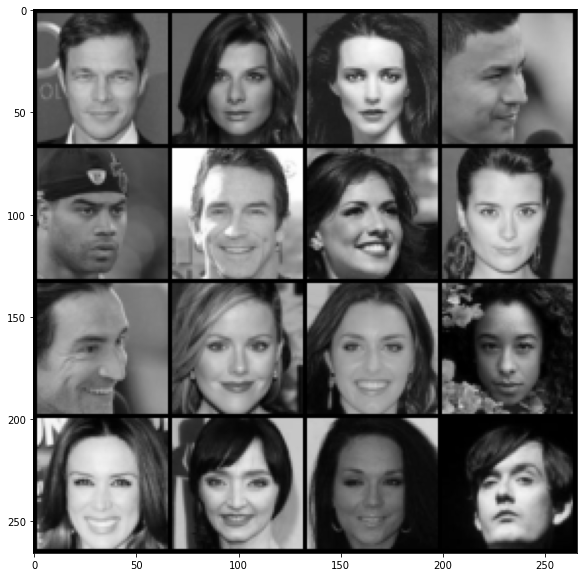

In [7]:
#!L
# print some images
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates a face (small image)
* make up a __measure__ of __how good this face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [8]:
#!L
def sample_noise_batch(batch_size, CODE_SIZE=100):
    noise = torch.randn(batch_size, CODE_SIZE, 1, 1).to(device)
    return noise
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# I want to implement DCGAN so let's go!

class Generator(nn.Module):
    def __init__(
        self,
        n_input_channels = 1,
        z_dim = 100,
        image_size = 64,
        generator_feature_map_size = 64
    ):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 8 * generator_feature_map_size, 4, 1, 0, bias=False),
            nn.BatchNorm2d(8 * generator_feature_map_size),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(8 * generator_feature_map_size, 4 * generator_feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4 * generator_feature_map_size),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(4 * generator_feature_map_size, 2 * generator_feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2 * generator_feature_map_size),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(2 * generator_feature_map_size, generator_feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_map_size),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(generator_feature_map_size, n_input_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.generator(input)

generator = Generator()
generator.apply(weights_init)
if use_cuda:
    generator = generator.to(device)

In [11]:
# #!L
CODE_SIZE = 100 # Size of z noise vector; feel free to change it

# generator = nn.Sequential()

# ## YOUR CODE - create architecture for discriminator
# ## Note: please start simple. You can start with the layers below, but you are more than welcome to change it

# generator.add_module('linear1', nn.Linear(CODE_SIZE, 10*8*8))
# generator.add_module('act1', nn.ELU())
# generator.add_module('reshape1', Reshape([-1, 10, 8, 8]))

# generator.add_module('conv2', nn.ConvTranspose2d(10, 64, kernel_size=(3,3)))
# generator.add_module('act2', nn.ELU())

# ##TODO: define next layers

# if use_cuda: generator.cuda()

In [12]:
#!L
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [13]:
#!L
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0).to(device)
    return batch

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [14]:
class Discriminator(nn.Module):
    def __init__(
        self,
        n_input_channels=1,
        discriminator_feature_map_size=64
    ):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(n_input_channels, discriminator_feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(discriminator_feature_map_size, 2 * discriminator_feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2 * discriminator_feature_map_size),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(2 * discriminator_feature_map_size, 4 * discriminator_feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4 * discriminator_feature_map_size),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(4 * discriminator_feature_map_size, 8 * discriminator_feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8 * discriminator_feature_map_size),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(8 * discriminator_feature_map_size, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.discriminator(input)

discriminator = Discriminator()
discriminator.apply(weights_init)
if use_cuda:
    discriminator = discriminator.to(device)

In [15]:
# #!L
# discriminator = nn.Sequential()

# ## YOUR CODE - create convolutional architecture for discriminator
# ## Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

# discriminator.add_module("disc_logit", nn.Linear(<???>, 1))

# if use_cuda: discriminator.cuda()

In [16]:
#!L
discriminator(sample_data_batch(4))

tensor([[[[-1.0089]]],


        [[[ 0.0389]]],


        [[[ 2.3301]]],


        [[[ 1.5944]]]], device='cuda:0', grad_fn=<ConvolutionBackward0>)

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [17]:
#!L
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
#     generated_data = <generate data given noise>
    b_size = noise.shape[0]
    generated_data = generator(noise)
    
#     disc_on_generated_data = <discriminator's opinion on generated data>
    disc_on_generated_data = discriminator(generated_data).view(-1)
    
    p_gen_is_real = torch.sigmoid(disc_on_generated_data).cpu()
    label_real = torch.full((b_size,), 1.0, dtype=torch.float)
    
#     loss = <generator loss. Mind the sign!>
    loss = F.binary_cross_entropy(p_gen_is_real, label_real)
    
    return loss

In [18]:
#!L
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.2861, grad_fn=<BinaryCrossEntropyBackward0>)


In [19]:
#!L
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    b_size = real_data.shape[0]
#     disc_on_real_data = <discriminator's prediction on real data>
    disc_on_real_data = discriminator(real_data).view(-1)
#     disc_on_fake_data = <discriminator's prediction on generated data>
    disc_on_fake_data = discriminator(generated_data).view(-1)
    
    p_real_is_real = torch.sigmoid(disc_on_real_data).cpu()
    p_gen_is_fake = torch.sigmoid(disc_on_fake_data).cpu()
    
    label_real = torch.full((b_size,), 1.0, dtype=torch.float)
    label_fake = torch.full((b_size,), 0.0, dtype=torch.float)
    
    loss = F.binary_cross_entropy(p_gen_is_fake, label_fake) + \
        F.binary_cross_entropy(p_real_is_real, label_real)
    return loss

In [20]:
#!L
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(2.1082, grad_fn=<AddBackward0>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [21]:
#!L
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(0, 1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size))).view(-1)
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch)).view(-1)
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [22]:
#!L
# optimizers
# disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [23]:
len(train_dataset) / 100

1627.7

In [ ]:
#!L
from IPython import display
from tqdm.auto import tqdm

batch_size = 100
loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True, drop_last=True)

for epoch in range(10):
    for iteration, (batch, _) in tqdm(enumerate(loader)):
        print(epoch * 1628 + iteration)
        disc_opt.zero_grad()

        # Train discriminator
        real_data = batch.to(device)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        loss.backward()
        disc_opt.step()

        # Train generator
#         if iteration % 5 == 0:
        gen_opt.zero_grad()
        noise = sample_noise_batch(batch_size)
        loss = generator_loss(noise)
        loss.backward()
        gen_opt.step()

        if iteration % 100 == 0:
            print(loss)
            display.clear_output(wait=True)
            sample_images(2,3,True)
            sample_probas(1000)
        

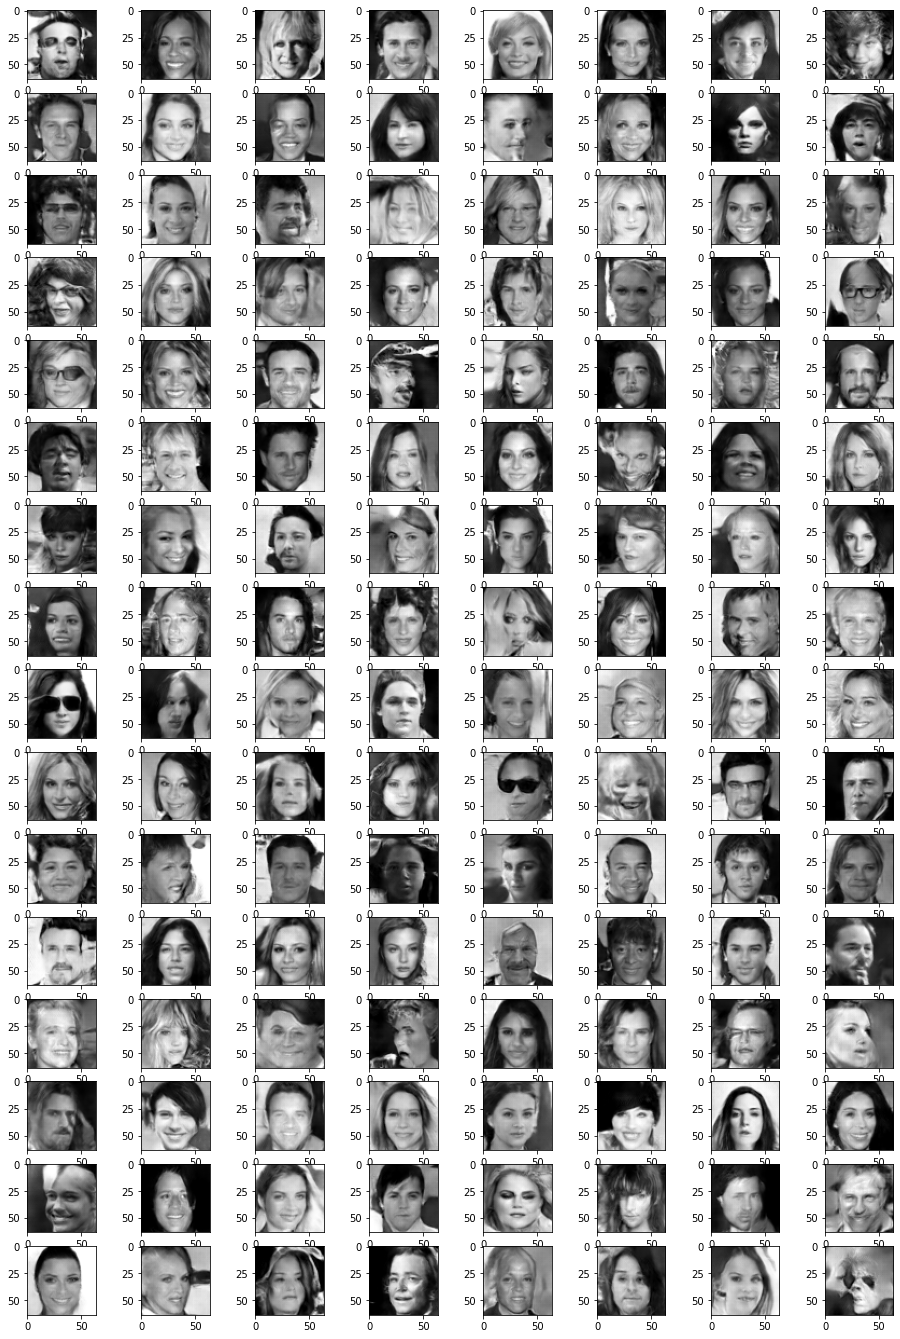

In [25]:
#!L
plt.figure(figsize=[16, 24])
sample_images(16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better